# DQN - double network

- ReplayBuffer
- Qnet
- train()
- main()

## Observation space

- force = -1 or 1
- x, x_dot, theta, theta_dot = observation
- -2.4 <= x <= 2.4
- -inf < x_dot < inf
- -12º <= theta <= 12º
- -inf < theta_dot < inf
  
## References

- https://github.com/seungeunrho/minimalRL/blob/master/dqn.py

In [1]:
%matplotlib inline
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import gym
from collections import deque
import random
import math
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
class ReplayBuffer():
    def __init__(self, buffer_limit = 50000):
        self.buffer = deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        state_list, action_list, reward_list, next_state_list, running_mask_list = [], [], [], [], []
        
        for transition in mini_batch:
            state, action, reward, next_state, running_mask = transition
            state_list.append(state)
            action_list.append([action])
            reward_list.append([reward])
            next_state_list.append(next_state)
            running_mask_list.append([running_mask])

        return torch.tensor(state_list, dtype=torch.float), torch.tensor(action_list), \
               torch.tensor(reward_list), torch.tensor(next_state_list, dtype=torch.float), \
               torch.tensor(running_mask_list)
    
    def __len__(self):
        return len(self.buffer)

In [4]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else:
            out = self.forward(obs)
            return out.argmax().item()

In [5]:
def plot_rewards(scores, epsilons):
    plt.plot(
        tuple(range(len(scores))),
        tuple(h for h in scores)
    )
    plt.draw()
    plt.show()

    plt.plot(
        tuple(range(len(epsilons))),
        tuple(h for h in epsilons)
    )
    plt.draw()
    plt.show()

In [6]:
def run(q, epsilon, env, replay_buffer):
    state = env.reset()

    for i in range(1000):
        action = q.sample_action(torch.from_numpy(state).float(), epsilon)

        next_state, reward, done, info = env.step(action)
        running_mask = 0.0 if done else 1.0

        replay_buffer.put((state, action, reward, next_state, running_mask))
            
        if done:
            return i
        else:
            state = next_state
    
    raise Exception("Infinite loop encountered!")
    
def train(q, q_target, memory, optimizer, gamma = 0.98, batch_size=32):
    for _ in range(10):
        state, action, reward, next_state, running_mask = memory.sample(batch_size)

        q_out = q(state)
        
        q_action = q_out.gather(1,action)
        
        max_q_target_next = q_target(next_state).max(1)[0].unsqueeze(1)
        target = reward + gamma * max_q_target_next * running_mask
        
        loss = F.smooth_l1_loss(q_action, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def main(q_net, init_epsilon = 0.5, target_epsilon = 0.001, n_iterations = 10000, learning_rate = 0.0005):
    assert target_epsilon <= init_epsilon

    env = gym.make('CartPole-v1')
    
    replay_buffer = ReplayBuffer()    
    q_net = deepcopy(q_net)
    q_target_net = deepcopy(q_net)
    
    all_rewards = []
    all_epsilons = []
    
    avg_window = 50
    avg_rewards = []
    avg_epsilons = []
    
    epsilon = init_epsilon
    decay = math.e ** (math.log(target_epsilon/epsilon) / (n_iterations - 1))
    
    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

    for i in range(n_iterations):
        reward = run(q_net, epsilon, env, replay_buffer)
        all_rewards.append(reward)
        all_epsilons.append(epsilon)
        
        if len(replay_buffer) > 5000:
            train(q_net, q_target_net, replay_buffer, optimizer)
            
            if i % 20 == 0:
                q_target_net = deepcopy(q_net)
        
        epsilon *= decay

        if len(all_rewards) >= avg_window:
            avg_reward = np.average(all_rewards[i-avg_window+1:i+1])
            avg_epsilon = np.average(all_epsilons[i-avg_window+1:i+1])
            
            if avg_reward >= 499 and epsilon < 0.05:
                break
            
            avg_rewards.append(avg_reward)
            avg_epsilons.append(avg_epsilon)
            
            if i % 1000 == 0:
                print(i, avg_reward, avg_epsilon)
    
    print(i, avg_reward, avg_epsilon)
    print(f"epsilon={epsilon}")
    print(f"q={q_net}")
    
    env.close()

    return q_net, all_rewards, avg_rewards, avg_epsilons

1000 103.36 0.2726946500083153
2000 97.68 0.1464713298939324
3000 144.22 0.07867352909286277
4000 124.18 0.04225758163326341
5000 317.72 0.02269763700804829
6000 485.86 0.012191486257310867
6571 499.0 0.008549290089107044
epsilon=0.008414523418235568
q=Qnet(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


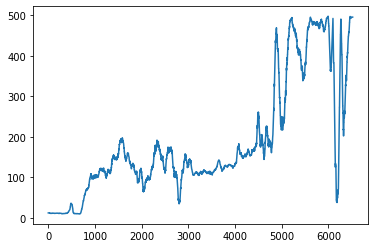

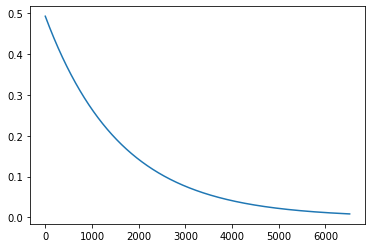

In [7]:
q_net_0 = Qnet()
q_net_1, all_rewards, avg_rewards, avg_epsilons = main(q_net_0)
plot_rewards(avg_rewards, avg_epsilons)

In [8]:
def display_frames_as_video(frames):
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    plt.axis('off')
    
    ims = []
    for i, frame in enumerate(frames):
        im = plt.imshow(frame, animated=True)
        ims.append([im])
        
    anim = animation.ArtistAnimation(fig, ims, interval=40, blit=True, repeat=False)
    display(HTML(anim.to_html5_video()))
    plt.close()

def test(q):
    max_step = 1000
    env = gym.make('CartPole-v1')
    env._max_episode_steps = max_step
    state = env.reset()
    
    frames = []

    for i in range(max_step):
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        action = q.sample_action(torch.from_numpy(state).float(), 0)
        state, reward, done, info = env.step(action)
        if done:
            print(i)
            break
    env.close()
    display_frames_as_video(frames)

In [9]:
test(q_net_1)

999


In [10]:
# q_net_2, all_rewards, avg_rewards, avg_epsilons = main(q_net_1, init_epsilon=0.001, target_epsilon=0.0001, n_iterations=5000)
# plot_rewards(avg_rewards, avg_epsilons)

In [11]:
# test(q_net_2)

In [12]:
# print("q_net_0", [param.data for param in q_net_0.parameters()])
# print("q_net_1", [param.data for param in q_net_1.parameters()])
# print("q_net_2", [param.data for param in q_net_2.parameters()])